Student IDs: 810100462 & 810100410
    
selected model: 2 -> SqueezeNet

**model architecture:** The SqueezeNet architecture is comprised of "squeeze" and "expand" layers. A squeeze convolutional layer has only 1 × 1 filters. These are fed into an expand layer that has a mix of 1 × 1 and 3 × 3 convolution filters.

The authors of the paper use the term “fire module”  to describe a squeeze layer and an expand layer together.

An input image is first sent into a standalone convolutional layer. This layer is followed by 8 "fire modules" which are named “fire2-9”, according to Strategy One above.

Following Strategy Two, the filters per fire module are increased with "simple bypass." Lastly, SqueezeNet performs max-pooling with a stride of 2 after layers conv1, fire4, fire8, and conv10. According to Strategy Three, pooling is given a relatively late placement, resulting in SqueezeNet with a "complex bypass".

Below are the details of other parameters used in the network:
* The ReLU activation is applied between all the squeeze and expand layers inside the fire module.
* Dropout layers are added to reduce overfitting, with a probability of 0.5 after the fire9 module.
* There are no fully connected layers used in the network. This design choice was inspired by the Network In Netowork (NIN) architecture proposed by (Lin et al, 2013).
* SqueezeNet was trained with a learning rate of 0.04, which is linearly decreased throughout the training process.
* The batch size for training is 32, and the network used an Adam Optimizer.

**pros and cons:** SqueezeNet makes the deployment process easier due to its small size.

SqueezeNet has two disadvantages: low classification accuracy and high computational complexity.

**initial preprocess:** All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean and std.

**Transfer Learning** is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task.

To put it simply—a model trained on one task is repurposed on a second, related task as an optimization that allows rapid progress when modeling the second task.

By applying transfer learning to a new task, one can achieve significantly higher performance than training with only a small amount of data.

In [1]:
import torch

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

our model can classify animals.

In [7]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

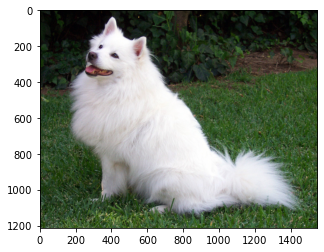

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
dog = Image.open('dog.jpg')
imgplot = plt.imshow(dog)

In [8]:
from PIL import Image
from torchvision import transforms

input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model(input_batch)


probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [9]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2022-04-15 09:09:56--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-04-15 09:09:56 (74.9 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [10]:
_, indices = torch.topk(probabilities, 3)
for index in indices:
    print('Object {} with probability {}'.format(categories[index], probabilities[index]))

Object Samoyed with probability 0.8526738882064819
Object Pomeranian with probability 0.03457362577319145
Object West Highland white terrier with probability 0.02477547898888588
